# <center>Custom Autodiff</center>

In this project, you will learn to build a reasonably self-sufficient Custom AutoDiff and test the same by comparing your output against an identical Feed-forward neural network implemented using Tensorflow. 
Later, you will perform a set of experiments to get a better feel of:
- the difficulties in optimizing certain Neural Network Architectures. 
- solutions for improving the performance. 
- the sensitivity to learning-rate in certain Architectures, etc. 

We will use the MNIST data for this project


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random 
import tensorflow as tf
import numpy as np
tf.__version__

'1.14.0-rc1'

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

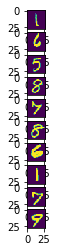

In [0]:
# Load MNIST Data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
print(train_data.shape)
print(train_labels.shape)
print(eval_data.shape)
print(eval_labels.shape)
# Randomly choose 10 images from first 50 images of Train Data.
for index,idx in enumerate(random.sample(range(50),10)): 
    plt.subplot(10,1,index+1)
    plt.imshow(train_data[idx].reshape(28,28))

## Custom AutoDiff

The code for the Custom AutoDiff is in the file CustomAutoDiff.py.

The following is the quick summary of the features and limitations:
- Every node in the graph is considered a Variable. This means that the gradient will be computed with respect to "constants" (Ex: inputs,outputs,etc) even though we do not need the gradients. 
- Every Variable should be represented as a 2D array. A scalar is automatically converted to a 2D array as required. 
- The following lists the set of supported operations and their syntax:
    * $e^\mathbf{x}$ => `x.exp()`
    * $log(\mathbf{x})$ => `x.log()`
    * Matrix-Addition (allows broadcasting) => `x + y`
    * Elementwise-Multiplication (allows broadcasting) => `x * y`
    * Elementwise-Division (allows broadcasting) => `x/y`
    * Matrix-Multiplication => `x @ y`
    * Sum along the dimension D => `x.reduce_sum(axis=D)`
        - Allows only 1 axis at a time.
        - All operations retain the rank of x.
    * Activation Functions (Sigmoid, Tanh, ReLU): `ReLU(x)`
- Automatically converts a numpy object/list/scalar into a `Variable`. However, the first operand of the operation should be a `Variable`. If `x = Variable([[1,2,3]])`:
    * `x+10` is valid.
    * `10+x` is not! (Why?) 

In [0]:
%load_ext autoreload
%autoreload 2

# The autoreload helps in automatically reloading the module as soon as 
# it changes on the disk. 
import CustomAutoDiff as cad

In [0]:
%reload_ext autoreload

In [0]:
def test():
    """
    Tests MatrixMultiplication.
    """
    v1 = cad.Variable([[1,2],
                       [3,4]])
    v2 = cad.Variable([[1],
                       [3]])
    
    mult_ = v1 @ v2
    print("MatMul")
    print(mult_.value)
    
    mult_.gradient = np.array([[1],
                               [3]])
    
    mult_.backward()
    
    print("Derivatives")
    print(v1.gradient)
    print(v2.gradient)
test()

MatMul
[[ 7.]
 [15.]]
Derivatives
[[1. 3.]
 [3. 9.]]
[[10.]
 [14.]]


In [0]:
def test():
    """
    Tests MatrixAddition (Broadcasting).
    Check by transposing v2 as well.
    """
    v1 = cad.Variable([[1,2],
                       [3,4]])
    v2 = cad.Variable([[1],
                       [3]])
    # Repeat the test by uncommenting the next line.
    #v2.value = v2.value.T 
    sum_ = v1 + v2
    print("Sum")
    print(sum_.value)
    
    sum_.gradient = np.array([[1,0],
                              [0,3]])
    
    sum_.backward()
    print("Derivatives")
    print(v1.gradient)
    print(v2.gradient)    
test()

Sum
[[2. 3.]
 [6. 7.]]
Derivatives
[[1 0]
 [0 3]]
[[1]
 [3]]


In [0]:
def test():
    """
    Tests reduce_sum, log, exp, MatrixDivision and ElementwiseMultiplication.
    """
    v = cad.Variable([[1,2,3],
                      [3,10,5]])
    sm = v.exp()/v.exp().reduce_sum(axis=1)
    print("Softmax output")
    print(sm.value)
    
    loss = (sm.log()*([[0,1,0],
                      [1,0,0]])).reduce_sum(axis=0).reduce_sum(axis=1)
    print("Loss")
    print(loss.value)
    
    loss.gradient = 1
    loss.backward()
    
    print("Derivative wrt softmax")
    print(sm.gradient)
    
    print("Derivative wrt logits")
    print(v.gradient)
test()

Softmax output
[[9.00305732e-02 2.44728471e-01 6.65240956e-01]
 [9.04959183e-04 9.92408247e-01 6.68679417e-03]]
Loss
[[-8.41522668]]
Derivative wrt softmax
[[   0.            4.08616127    0.        ]
 [1105.02221453    0.            0.        ]]
Derivative wrt logits
[[-0.09003057  0.75527153 -0.66524096]
 [ 0.99909504 -0.99240825 -0.00668679]]


In [0]:
activation_map = {
    "sigmoid": [cad.Sigmoid,tf.sigmoid],
    "relu": [cad.ReLU,tf.nn.relu],
    "tanh": [cad.Tanh,tf.tanh]
}

## Custom NN

Already done for you, answer the questions in the comments. 

In [0]:
class CustomNN:
    def __init__(self,conf):
        self.weights = [cad.Variable(weight) for weight in conf.weights]
        self.biases = [cad.Variable(bias) for bias in conf.biases]
        self.activations = [activation_map[activation][0] for activation in conf.activations]
        self.learning_rate = conf.learning_rate
        self.mu = conf.momentum
        
    def forward(self,batch):
        # Describe what the following function does. 
        '''
        The function use for loop to iterate each weight, bias and activations that are zip together.
        it also define the logits and softmax function when foward pass. 
        This is similar to building the computation graph in Tensorflow.
        '''
        temp = cad.Variable(batch)
        for weight,bias,act in zip(self.weights,self.biases,self.activations):
            temp = temp@weight+bias
            temp = act(temp)
        logits = temp@self.weights[-1]+self.biases[-1]
        softmax = logits.exp()/logits.exp().reduce_sum(axis=1)
        return logits.value
    
    def loss_and_gradients(self,batch,targets):
        for param in self.weights+self.biases:
            param.reset()
            
        temp = cad.Variable(batch)
        for weight,bias,act in zip(self.weights,self.biases,self.activations):
            temp = temp@weight+bias
            temp = act(temp)
        
        logits = temp@self.weights[-1]+self.biases[-1]
        
        # Why do we do this? 
        '''
        The reason we do this is to stable network in an numerical way. 
        In softmax the exponential function increases very fast, 
        to increase the stability we can subtract the maximum value withou make change to the softmax result. 
        '''
        logits = logits + (-logits.value.max(axis=1,keepdims=True))
        softmax = logits.exp()/logits.exp().reduce_sum(axis=1)
        
        # Why did we add 10**-6 to softmax?
        '''
        We add this is because we want to control the percision of the results
        '''
        # Why did we multiply with "-targets"?
        '''
        This looks like the Cross Entropy loss to me, the functiong is defined like this, 
        so that  the reason we multiply with negative target.
        or in an neumerical way we could say we want our loss to be positive 
        softmax is a decimal number between 0 and 1 the log of it would be negative,
        if we want to get positive loos we multiply a negative number which is the negative of target. 
        '''
        loss = ((softmax+10**-6).log() * cad.Variable(-targets)).reduce_sum(axis=0).reduce_sum(axis=1)/batch.shape[0]
        
        loss.gradient = 1
        loss.backward()
        return {
            "loss" :loss.value,
            "grads":[param.gradient for param in (self.weights+self.biases)]
        }
    
    def apply_gradients(self):
        #initial velocity is zero
        v = 0
        for param in self.weights+self.biases:
            param.value -= self.learning_rate * param.gradient
            
            param.reset()

## Tensorflow NN

Already done for you, answer the questions in the comments. 

In [0]:
class TensorflowNN:
    def __init__(self,conf):
        # Why is it a good idea to build the compute graph within the tf.Graph scope?
        '''
        1: Tensorflow's session will caches information about the graph
        2: For parallesims, differetn part of the graph can run in parallel to save computation time. 
        '''
        g = tf.Graph()
        with g.as_default():
            # Define the placeholders
            self.input = tf.placeholder(dtype=tf.float64, shape=(None, 784))
            self.expected_output = tf.placeholder(dtype=tf.float64, shape=(None, 10))
            
            self.weights = [tf.Variable(dtype=tf.float64,initial_value=weight) for weight in conf.weights]
            self.biases = [tf.Variable(dtype=tf.float64,initial_value=bias) for bias in conf.biases]

            # Build the graph for computing output.
            layer = self.input
            for i in range(0, len(conf.activations)):
                layer = layer@self.weights[i] + self.biases[i]
                layer = activation_map[conf.activations[i]][1](layer)
            
            # For output layer
            self.logits = layer@self.weights[-1] + self.biases[-1]
            logits = self.logits - tf.reduce_max(self.logits,axis=1,keepdims=True)
            
            self.output = tf.exp(logits)/tf.reduce_sum(tf.exp(logits),axis=1,keepdims=True)
            self.loss = -tf.reduce_mean(tf.reduce_sum(tf.log(self.output+10**-6)*self.expected_output,axis=1))
            
            # Instantiate the optimizer
            #self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=conf.learning_rate)
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=conf.learning_rate)
            
            self.grads = self.optimizer.compute_gradients(self.loss)
            self.train_op = self.optimizer.apply_gradients(self.grads)
            
            self.session = tf.Session()
            
            # Initialize all variables
            self.session.run(tf.global_variables_initializer())
    
    def forward(self,batch):
        return self.session.run(self.logits,feed_dict={self.input:batch})
    
    def loss_and_gradients(self,batch,targets):
        return {
            "loss" :self.session.run(self.loss,feed_dict={self.input:batch,self.expected_output:targets}),
            "grads":self.session.run(tf.gradients(self.loss,self.weights+self.biases),feed_dict={self.input:batch,self.expected_output:targets})
        }
    
    def apply_gradients(self,batch,targets):
        self.session.run(self.train_op,feed_dict={self.input:batch,self.expected_output:targets})

## Comparing Custom NN and Tensorflow NN

Just run the following code snippets after filling out CustomAutoDiff.py.

Preparing weights

In [0]:
class Conf:
    def __init__(self,hidden_layers,activations,learning_rate,momentum):
        number_units = [784] + hidden_layers + [10]
        weights = []
        biases = []
        for prev,curr in zip(number_units,number_units[1:]):
            np.random.seed(1)
            weights.append(np.random.randn(prev,curr))
            biases.append(np.zeros([1,curr],dtype=np.float32))
        self.weights = weights
        self.biases = biases
        self.activations = activations
        self.learning_rate = learning_rate

conf = Conf(hidden_layers=[300],
           activations=["sigmoid"],
           learning_rate=0.1)
"""
Let's create two instances of the above Neural Network configuration - 
one built on custom AutoDiff framework and the other built on Tensorflow Library. 
"""

customNN = CustomNN(conf)
tensorNN = TensorflowNN(conf)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


We will first make sure that our code is correct by comparing the results against that of Tensorflow's. 

<b>Comparing forward pass</b>

In [0]:
idx = random.choice(range(len(train_data)))
t1 = customNN.forward(train_data[idx:idx+5])
t2 = tensorNN.forward(train_data[idx:idx+5])
print((np.abs(t2-t1)<10**-6).all())

True


<b>Comparing Gradients</b>

In [0]:

idx = random.choice(range(train_data.shape[0]))
t1 = customNN.loss_and_gradients(train_data[idx:idx+5],train_labels[idx:idx+5])
t2 = tensorNN.loss_and_gradients(train_data[idx:idx+5],train_labels[idx:idx+5])
print(t1["loss"],t2["loss"])
for i,j in zip(t1["grads"],t2["grads"]):
   
    print((np.abs(j-i)<10**-6).all())

[[13.59392699]] 13.593926991094104
True
True
True
True


<b>Comparing Test Accuracies for 10 steps of training </b>

In [0]:
for epoch in range(10):
    for idx in range(0,train_data.shape[0],128):
        # TensorNN update
        tensorNN.apply_gradients(train_data[idx:idx+128],train_labels[idx:idx+128])
        
        # CustomNN update
        loss_and_grads1 = customNN.loss_and_gradients(train_data[idx:idx+128],train_labels[idx:idx+128])
        customNN.apply_gradients()
    
    tensorNN_correct = 0
    customNN_correct = 0
    for idx in range(0,eval_data.shape[0],128):
        expected = eval_labels[idx:idx+128]
        
        # TensorNN Accuracy
        preds = tensorNN.forward(eval_data[idx:idx+128])
        tensorNN_correct += (np.argmax(preds,axis=1)==np.argmax(expected,axis=1)).sum()
        
        # CustomNN Accuracy
        preds = customNN.forward(eval_data[idx:idx+128])
        customNN_correct += (np.argmax(preds,axis=1)==np.argmax(expected,axis=1)).sum()
    
    print("Epoch {}: {} {}".format(epoch,tensorNN_correct/eval_data.shape[0],customNN_correct/eval_data.shape[0]))

Epoch 0: 0.7526 0.7526
Epoch 1: 0.8178 0.8178
Epoch 2: 0.8454 0.8454
Epoch 3: 0.86 0.86
Epoch 4: 0.8702 0.8702
Epoch 5: 0.8795 0.8795
Epoch 6: 0.8845 0.8845
Epoch 7: 0.8894 0.8894
Epoch 8: 0.8942 0.8942
Epoch 9: 0.8971 0.8971



Now that you have been able to successfully reproduce Tensorflow Results using a custom framework!